#### Introduction

For this study case the objective was to use Twitter API to identify influencers in different topics. The choosen topic was ('bitcoin'). In order to realize the problem, I built up the following assumptions that will help construct the model: 

- They(influencers) will have a big number of followers (this is subjective depending on the area of expertise)
- They will have low number of friends (friends are followers who are being followed back)
- They make the news, so, I expect very rare use of hashtags
- They have good to very good engagement rate 
    - Quoting (https://blog.scrunch.com/what-is-a-good-engagement-rate-on-twitter): 
        - "An engagement rate between 0.09% and 0.33% is considered to be high, where an influencer would expect 9 - 33 reactions for every 1000 followers on Twitter."
        - "Finally, an engagement rate between 0.33% and 1% is considered to be very high, with expected reactions to be between 3 - 10 for every 1000 Twitter followers."
- From network analysis perspectives, I assume that influencers will be categorized into two types: 
    - community core
    - bridge
- They are good at making predictions, for this, I will use an event as a test and capture the predictions and the reality. I am going to focus on a period from October 2017 to February 2018, a period during which bitcoin increased by a factor of 4X (https://www.coindesk.com/900-20000-bitcoins-historic-2017-price-run-revisited/). I will be using this period to see of the assumed influencers, who are those who actually could make correct predictions. 

**Analysis**:
The analysis is going to be divided into the following steps:
- 1- Collect top 1000 tweets from October 2017 to February 2018, with intervals of 5 days. 
- 2- filter the tweets to keep those who have number of engagment (retweets+replies+favorites) higher than 100
- 3- build a database with following formats: username, userid, tweet, hashtags_used, number_of_hashtags, mentions_used, number_of_mentions, tweet_length, retweets, replies, favorites, lexical_power(vocab/len(tweet)), tweet_sentiment
- 4- build a network of every user 

**Tools**:
I am going to use "getoldtweets" (https://github.com/Jefferson-Henrique/GetOldTweets-python), a script to collect old scripts. I went with this solution because twitter API allows to search for a maximum of 7 days for standar search. When I built the network I use the regular twitter API, it easier, even if there is rate limitation. I am storing the data in a simple pandadataframe, but as the number grows it would be better to move to other solutions like MongoDB
Note: I am using python version 3.5, and the script of getoldtweets was modified for it since the running version is 2.7, and the depencies are found in requirements.txt (pip install -r requirements.txt)

**What have been done so far**:
When i started working on this problem, i started to collect tweets from the API. however, I saw that it fell short as i was developing more assumptions about how to approach the problem. Then, I moved to look for a solution that would allow me to collect older tweets, more specifically tweets in the period i am interested in. the script "getoldtweets" was a good solution to start with, however, i need to make some changes to the code to corretly collect: text, username, user_id, hashtags, mentions, and replies. At the end, i managed to get the variables i was interested in. Then i proceeded to collect a sample and construct the social network.

**challenges**:
At this stage i didn't manage to conduct meaningful analysis and this due to the time wasted on finding a solution to collect tweets of interests. This taks took more time than expected and I didn't well to manage my time to be able to manage all the parts of the problem


**what is left to do**:
- run the script to collect higher number of tweets
- conduct the analysis and cluster influencers using clustering algorithm (ex: K-means or PCA)
- optional: one way to improve the clustering would be to use a simple statistical test (ex: t-test) to confirm that there is a difference between influencers and other users in the dataset
- construct a bigger network, and test the predictions



In [1]:
# getoldtweets package 
import got3 as got

# import twitter
import twitter
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import re
import string

import networkx as nx
import nxviz as nv

In [52]:
# script of main.py
def main():
 
    def printTweet(descr, t):
        print(descr)
        print("Username: %s" % t.username)
        print("Retweets: %d" % t.retweets)
        print("Text: %s" % t.text)
        print("Mentions: %s" % t.mentions)
        print("Hashtags: %s\n" % t.hashtags)
 
    # Example 1 - Get tweets by username
    tweetCriteria = got.manager.TweetCriteria().setUsername('barackobama').setMaxTweets(1)
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)[0]
 
    printTweet("### Example 1 - Get tweets by username [barackobama]", tweet)
 
    # Example 2 - Get tweets by query search
    tweetCriteria = got.manager.TweetCriteria().setQuerySearch('europe refugees').setSince("2015-05-01").setUntil("2015-09-30").setMaxTweets(1)
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)[0]
 
    printTweet("### Example 2 - Get tweets by query search [europe refugees]", tweet)
 
    # Example 3 - Get tweets by username and bound dates
    tweetCriteria = got.manager.TweetCriteria().setUsername("barackobama").setSince("2015-09-10").setUntil("2015-09-12").setMaxTweets(1)
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)[0]
 
    printTweet("### Example 3 - Get tweets by username and bound dates [barackobama, '2015-09-10', '2015-09-12']", tweet)
 
if __name__ == '__main__':
    main()

### Example 1 - Get tweets by username [barackobama]
Username: BarackObama
Retweets: 37124
Text: Mandela Day is about taking action to change the world for the better. In these young people, I see Madiba's example of persistence and hope. They are poised to make this world more peaceful, more prosperous, and more just.pic.twitter.com/GJDuOs1hkH
Mentions: 
Hashtags: 

### Example 2 - Get tweets by query search [europe refugees]
Username: jerranspearman3
Retweets: 0
Text: [106] Europe's Refugees & American Elections w/ Chris Hedges https://youtu.be/GYqgj3l4r18 via @YouTube
Mentions: @YouTube
Hashtags: 

### Example 3 - Get tweets by username and bound dates [barackobama, '2015-09-10', '2015-09-12']
Username: BarackObama
Retweets: 6567
Text: "The events of September 11, 2001, left a permanent mark on the spirit of every American." —President Obamapic.twitter.com/oob3Hc0vmi
Mentions: 
Hashtags: 



In [2]:
# timeperiod tuple 
timeperiod = (('2017',('10','11','12')), ('2018',('01','02')))

In [20]:
data = {'username':[], 'userid':[], 'tweet':[], 'tweet_length':[], 'hashtags_used':[], 'mentions_used':[], 'retweets':[], 'replies':[], 'favorites':[]}
for years in timeperiod:
    for month in years[1]:
        start = 1
        end   = 5
        while end<31:
            startdate = '-'.join([years[0],month,format(start,'02d')])
            enddate = '-'.join([years[0],month,format(end,'02d')])
            print('Processing for : ',startdate,enddate)
            start = end + 1
            end = end + 5 
            tweetCriteria = got.manager.TweetCriteria().setQuerySearch('bitcoin').setSince(startdate).setUntil(enddate).setTopTweets(True).setMaxTweets(5)
            for tweetObject in got.manager.TweetManager.getTweets(tweetCriteria):
                engagement = tweetObject.retweets+tweetObject.replies+tweetObject.favorites
                if engagement >=100:
                    data['username'].append(tweetObject.username)
                    data['userid'].append(tweetObject.user_id)
                    data['tweet'].append(tweetObject.text)
                    data['tweet_length'].append(len(tweetObject.text))
                    data['hashtags_used'].append(tweetObject.hashtags)
                    data['mentions_used'].append(tweetObject.mentions)
                    data['retweets'].append(tweetObject.retweets)
                    data['replies'].append(tweetObject.replies)
                    data['favorites'].append(tweetObject.favorites)
    

Processing for :  2017-10-01 2017-10-05
Processing for :  2017-10-06 2017-10-10
Processing for :  2017-10-11 2017-10-15
Processing for :  2017-10-16 2017-10-20
Processing for :  2017-10-21 2017-10-25
Processing for :  2017-10-26 2017-10-30
Processing for :  2017-11-01 2017-11-05
Processing for :  2017-11-06 2017-11-10
Processing for :  2017-11-11 2017-11-15
Processing for :  2017-11-16 2017-11-20
Processing for :  2017-11-21 2017-11-25
Processing for :  2017-11-26 2017-11-30
Processing for :  2017-12-01 2017-12-05
Processing for :  2017-12-06 2017-12-10
Processing for :  2017-12-11 2017-12-15
Processing for :  2017-12-16 2017-12-20
Processing for :  2017-12-21 2017-12-25
Processing for :  2017-12-26 2017-12-30
Processing for :  2018-01-01 2018-01-05
Processing for :  2018-01-06 2018-01-10
Processing for :  2018-01-11 2018-01-15
Processing for :  2018-01-16 2018-01-20
Processing for :  2018-01-21 2018-01-25
Processing for :  2018-01-26 2018-01-30
Processing for :  2018-02-01 2018-02-05


In [23]:
data_df = pd.DataFrame(data)
data_df.head()

,favorites,hashtags_used,mentions_used,replies,retweets,tweet,tweet_length,userid,username
0,135,#bitcoin #goodoldtimespic,,11,15,The good old times ;-) #bitcoin #goodoldtimesp...,71,25803102,julianhosp
1,106,,,3,50,"The latest Bitcoin Price Index is 4,775.11 USD...",105,1333467482,coindesk
2,279,,,71,25,I'm taking a Twitter timeout on Bitcoin tweets...,138,1854401,VinnyLingham
3,105,,,5,47,Cool graph highlighting some of the exponentia...,121,40742821,TuurDemeester
4,128,#Jamie #Dimon #Bitcoin,,4,84,"#Jamie #Dimon may not see value in #Bitcoin, b...",206,2207129125,Cointelegraph


In [38]:
def clean(text):
    text = text.lower()
    text = ''.join([x for x in text if x not in string.punctuation])
    text = text.split()
    vocab = set(text)
    return len(vocab)/len(text)

In [39]:
data_df['number_of_hashtags'] = data_df['hashtags_used'].apply(lambda x: len(x.split()))
data_df['number_of_mentions'] = data_df['mentions_used'].apply(lambda x: len(x.split()))
data_df['lexical_power'] = data_df['tweet'].apply(clean)

In [42]:
data_df.head()

,favorites,hashtags_used,mentions_used,replies,retweets,tweet,tweet_length,userid,username,number_of_hashtags,number_of_mentions,lexical_power
0,135,#bitcoin #goodoldtimespic,,11,15,The good old times ;-) #bitcoin #goodoldtimesp...,71,25803102,julianhosp,2,0,1.00
1,106,,,3,50,"The latest Bitcoin Price Index is 4,775.11 USD...",105,1333467482,coindesk,0,0,1.00
2,279,,,71,25,I'm taking a Twitter timeout on Bitcoin tweets...,138,1854401,VinnyLingham,0,0,0.96
3,105,,,5,47,Cool graph highlighting some of the exponentia...,121,40742821,TuurDemeester,0,0,1.00
4,128,#Jamie #Dimon #Bitcoin,,4,84,"#Jamie #Dimon may not see value in #Bitcoin, b...",206,2207129125,Cointelegraph,3,0,1.00


In [43]:
# Twitter authentification
def oauth_login():
    
    CONSUMER_KEY = ''
    CONSUMER_SECRET = ''
    OAUTH_TOKEN = ''
    OAUTH_TOKEN_SECRET = ''
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

twitter_api = oauth_login()    

twitter_api

In [203]:
import time
def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):
    
        if wait_period > 3600: # Seconds
            print ('Too many retries. Quitting.')
            raise e
        
        if e.e.code == 401:
            print ('Encountered 401 Error (Not Authorized)')
            return None
        elif e.e.code == 404:
            print ('Encountered 404 Error (Not Found)')
            return None
        elif e.e.code == 429: 
            print ('Encountered 429 Error (Rate Limit Exceeded)')
            if sleep_when_rate_limited:
                print ("Retrying in 15 minutes...ZzZ...")
                time.sleep(60*15 + 5)
                print ('...ZzZ...Awake now and trying again.')
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print ('Encountered %i Error. Retrying in %i seconds' % (e.e.code, wait_period))
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

In [253]:
graph=nx.DiGraph()

usernames = data['username']
username = usernames[0]

dic_users = {}
try:
    # Load data
    print ("Loading users who follow",username)
    followers = []
    followers.extend(twitter_api.followers.ids(ids=username)['ids'])

    print ("Loading users that",username,"follows back")
    friends = []
    friends.extend(twitter_api.friends.ids(ids=username)['ids'])

    # Create graph
    print ("Adding followers relationships")
    for user in followers:
        followername = twitter_api.users.lookup(user_id=user)[0]['screen_name']
        graph.add_edge(followername,username)
        if followername not in dic_users:
            dic_users[user] = followername

    print ("Adding following relationships")
    for user in friends:
        followingname = twitter_api.users.lookup(user_id=user)[0]['screen_name']
        graph.add_edge(username,followingname)
        if followingname not in dic_users:
            dic_users[user] = followingname
except twitter.api.TwitterHTTPError as e:
    error_count = 0 
    wait_period = handle_twitter_http_error(e, wait_period)
    if wait_period is None:
        pass
    

Loading users who follow julianhosp
Loading users that julianhosp follows back
Adding followers relationships
Adding following relationships


In [204]:
wait_period = 2
for u in usernames[1:]:
    try:
        print ("Loading users who follow",u)
        followers = []
        followers.extend(twitter_api.followers.ids(ids=u)['ids'])

        print ("Loading users that",u,"follows back")
        friends = []
        friends.extend(twitter_api.friends.ids(ids=u)['ids'])

        print ("Adding followers relationships")
        for user in followers:
            followername = dic_users[user]
            graph.add_edge(followername,u)

        print ("Adding following relationships")
        for user in friends:
            followingname = dic_users[user]
            graph.add_edge(u,followingname)
    except twitter.api.TwitterHTTPError as e:
            error_count = 0 
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                break

Loading users who follow coindesk
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.
Loading users who follow VinnyLingham
Loading users that VinnyLingham follows back
Adding followers relationships
Adding following relationships
Loading users who follow TuurDemeester
Loading users that TuurDemeester follows back
Adding followers relationships
Adding following relationships
Loading users who follow Cointelegraph
Loading users that Cointelegraph follows back
Adding followers relationships
Adding following relationships
Loading users who follow BTCTN
Loading users that BTCTN follows back
Adding followers relationships
Adding following relationships
Loading users who follow atlantio
Loading users that atlantio follows back
Adding followers relationships
Adding following relationships
Loading users who follow sarahjeong
Loading users that sarahjeong follows back
Adding followers relationships
Adding following relationships
Loadi

In [110]:
# Save graph
nx.write_gexf(graph,"sample-network.gexf")


Saving the file as sample-network.gexf...


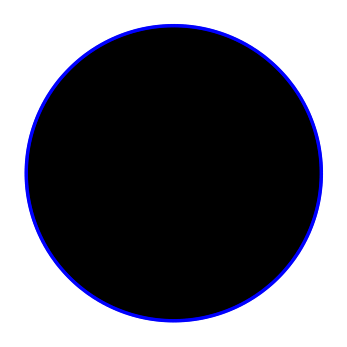

In [205]:
c = nv.CircosPlot(graph)
c.draw()

In [206]:
f = {}

In [207]:
for i in graph.edges(data=True):
    if i[1] in f:
        f[i[1]] += 1
    else:
        f[i[1]] = 1

In [208]:
g1 = graph.copy()

In [209]:
for n, d in g1.nodes(data=True):
    try:
        g1.node[n]['followers'] = f[n]
    except:
        g1.node[n]['followers'] = 0

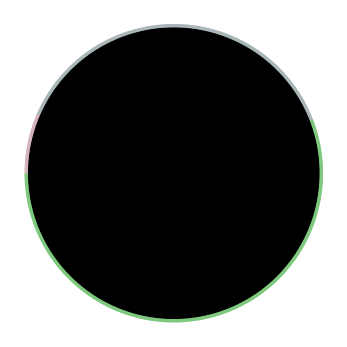

In [211]:
c = nv.CircosPlot(g1, node_order='followers', node_color='followers')
c.draw()